In [1]:
import pandas as pd
import numpy as np
# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML
import sklearn


In [2]:
# read data
df = pd.read_csv("data.csv")

# Data Inspection
The data is scrapped from PUBG's developer's website, with randomly generated match samples from three gaming platforms. Each match stores the match and player statistics. Squad is the most popular match type, followed by duo and solo. To better analyze the data, we normalized some columns as needed, and removed outliers that does not fit.



In [3]:
df.shape,df.columns

((173087, 23),
 Index(['playerId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
        'headshotKills', 'heals', 'killPlace', 'kills', 'killStreaks',
        'longestKill', 'matchDuration', 'matchType', 'revives', 'rideDistance',
        'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys',
        'walkDistance', 'weaponsAcquired', 'winPlace'],
       dtype='object'))

## Outlier Detection for Illegal Matches

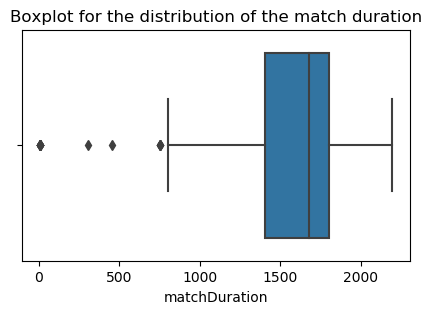

In [4]:
plt.style.use('default')
plt.figure(figsize = (5,3))
sns.boxplot(df.matchDuration)
plt.title("Boxplot for the distribution of the match duration")
plt.show()

There are some outliers in the match duration. With the median around 1600s and some matches only last for 8 seconds, we suspect some of the matches go wrong that could either caused by loading error or bug. 

In [5]:
# check for the games under normal length of duration
display(len(df[(df['matchDuration'] < 500)]['matchDuration']))
df[(df['matchDuration'] < 500)]['matchDuration']

12

87149     456
91096       8
96030       8
96187     309
99417       8
102400      8
110025      8
118365      8
118366      8
118367      8
127609      8
135300      8
Name: matchDuration, dtype: int64

In [6]:
# delete those data with match duratino shorter than 10 seconds
df = df.drop(index = df[(df['matchDuration'] < 10)].index).reset_index().drop(columns = ['index'])

In [7]:
df.shape

(173077, 23)

In [8]:
# check if exist illegal match where no players joined
df[(df.groupby("matchId")['playerId'].transform(len) == 0)]

,playerId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,kills,...,matchType,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPlace


# Feature Engineering

In [9]:
# player statistics are by match level. So we normalize the statistics by the number of players jonied.
df['playersJoined'] = df.groupby("matchId")['playerId'].transform(len)

In [10]:
# normalize feature winPlacePerc for the winning place by players joined for each match
df['winPlacePerc'] = df.groupby(df['matchId'])['winPlace'].transform(lambda x: (x.max()-x)/(x.max()-x.min()))
df['winPlacePerc'].fillna(0,inplace = True)

In [11]:
# normalize selected killing statistics by players joined for each match
df['killsNorm'] = df['kills']*((100-df['playersJoined'])/100 + 1)
df['damageDealtNorm'] = df['damageDealt']*((100-df['playersJoined'])/100 + 1)

In [12]:
# combine distances together and cerate feature totalDistance
df['totalDistance'] = df['rideDistance'] + df['walkDistance'] + df['swimDistance']


In [13]:
# create headshot_rate feature
df['headshot_rate'] = df['headshotKills'] / df['kills']
df['headshot_rate'] = df['headshot_rate'].fillna(0)

In [14]:
# create label assist and revives
df['assist_revives'] = df['assists'] + df['revives']

In [15]:
# create label boosts and heals
df['boost_heals'] = df['boosts'] + df['heals']

In [16]:
df.shape # 7 more features than original

(173077, 31)

In [17]:
df.columns

Index(['playerId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'kills', 'killStreaks',
       'longestKill', 'matchDuration', 'matchType', 'revives', 'rideDistance',
       'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys',
       'walkDistance', 'weaponsAcquired', 'winPlace', 'playersJoined',
       'winPlacePerc', 'killsNorm', 'damageDealtNorm', 'totalDistance',
       'headshot_rate', 'assist_revives', 'boost_heals'],
      dtype='object')

In [18]:
# drop unuseful columns
df = df.drop(columns = ['winPlace','kills','teamKills','damageDealt','DBNOs','killPlace','revives','assists','boosts','heals'])


In [19]:
df.columns

Index(['playerId', 'matchId', 'headshotKills', 'killStreaks', 'longestKill',
       'matchDuration', 'matchType', 'rideDistance', 'roadKills',
       'swimDistance', 'vehicleDestroys', 'walkDistance', 'weaponsAcquired',
       'playersJoined', 'winPlacePerc', 'killsNorm', 'damageDealtNorm',
       'totalDistance', 'headshot_rate', 'assist_revives', 'boost_heals'],
      dtype='object')

# Outlier Detection for Cheaters/Zombies/Anomalies of the game

## Really good players?

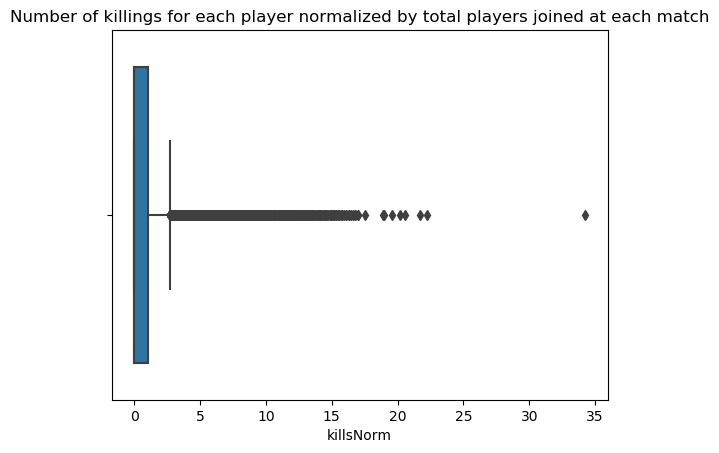

(33, 21)


In [20]:
# check players with abnormal kills in one match
sns.boxplot(df['killsNorm'])
plt.title("Number of killings for each player normalized by total players joined at each match")
plt.show()
print(df[(df['killsNorm'] > 15)].shape)
# remove outliers with too many kills
df = df.drop(index = df[(df['killsNorm'] > 15)].index).reset_index().drop(columns = ['index'])

In [21]:
# check players with abnormal damage dealt in one match
print(df[(df['damageDealtNorm'] > 1200)].shape)

# remove outliers with too many damage dealt in one game
df = df.drop(index = df[(df['damageDealtNorm'] > 1200)].index).reset_index().drop(columns = ['index'])

(248, 21)


## Cheaters?

(7, 21)

<Figure size 1000x500 with 0 Axes>

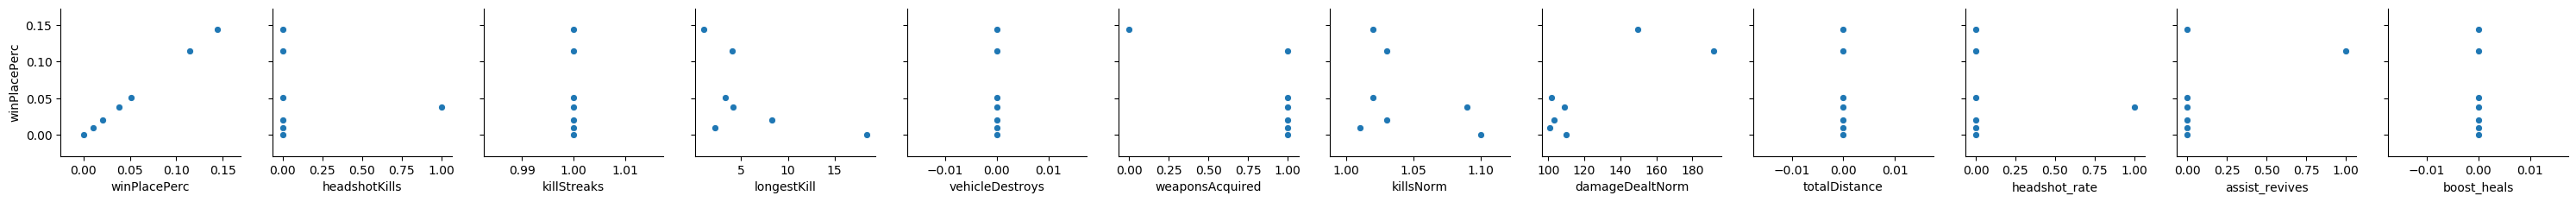

In [22]:
# check players who kills without moving
display(df[(df['killsNorm'] > 0) & (df['totalDistance'] == 0)].shape)

plt.figure(figsize = (10,5))
ax = sns.pairplot(x_vars = ['winPlacePerc','headshotKills', 'killStreaks', 'longestKill','vehicleDestroys',
                       'weaponsAcquired','killsNorm','damageDealtNorm',
                       'totalDistance', 'headshot_rate', 'assist_revives', 'boost_heals'],
             y_vars = 'winPlacePerc', data = df[(df['killsNorm'] > 0) & (df['totalDistance'] == 0)])
plt.show()

# who are these cheaters
df_cheaters = df[(df['killsNorm'] > 0) & (df['totalDistance'] == 0)]

In [23]:
df_cheaters.describe()

,headshotKills,killStreaks,longestKill,matchDuration,rideDistance,roadKills,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,playersJoined,winPlacePerc,killsNorm,damageDealtNorm,totalDistance,headshot_rate,assist_revives,boost_heals
count,7.000000,7.0,7.000000,7.000000,7.0,7.0,7.0,7.0,7.0,7.000000,7.000000,7.000000,7.000000,7.000000,7.0,7.000000,7.000000,7.0
mean,0.142857,1.0,5.905939,1464.714286,0.0,0.0,0.0,0.0,0.0,0.857143,95.714286,0.054207,1.042857,123.774140,0.0,0.142857,0.142857,0.0
std,0.377964,0.0,5.994029,121.568519,0.0,0.0,0.0,0.0,0.0,0.377964,3.638419,0.054756,0.036384,34.443125,0.0,0.377964,0.377964,0.0
min,0.000000,1.0,0.976856,1355.000000,0.0,0.0,0.0,0.0,0.0,0.000000,90.000000,0.000000,1.010000,100.999990,0.0,0.000000,0.000000,0.0
25%,0.000000,1.0,2.710111,1379.000000,0.0,0.0,0.0,0.0,0.0,1.000000,94.000000,0.015411,1.020000,102.500000,0.0,0.000000,0.000000,0.0
50%,0.000000,1.0,4.016906,1469.000000,0.0,0.0,0.0,0.0,0.0,1.000000,97.000000,0.038462,1.030000,109.000000,0.0,0.000000,0.000000,0.0
75%,0.000000,1.0,6.227583,1480.000000,0.0,0.0,0.0,0.0,0.0,1.000000,98.000000,0.082916,1.060000,129.867995,0.0,0.000000,0.000000,0.0
max,1.000000,1.0,18.472420,1711.000000,0.0,0.0,0.0,0.0,0.0,1.000000,99.000000,0.144330,1.100000,191.683000,0.0,1.000000,1.000000,0.0


According to this headshot rate distribution, there is an anomaly peak at 1.0  where all the kills are headshot kills. 

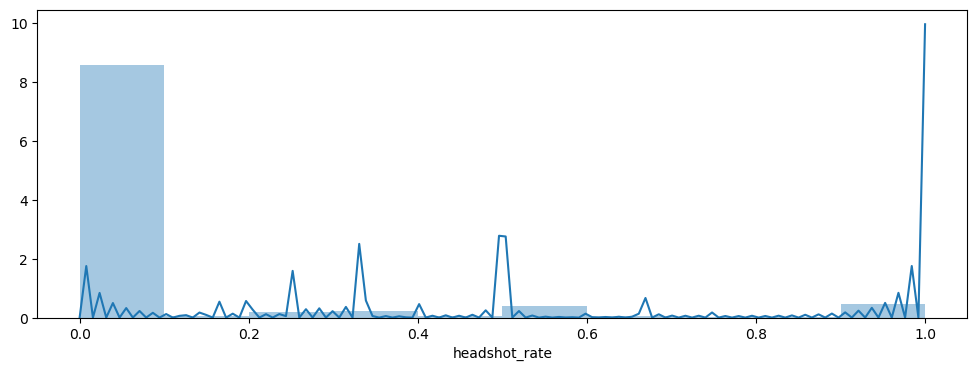

In [24]:
# Plot the distribution of headshot_rate
plt.figure(figsize=(12,4))
sns.distplot(df['headshot_rate'], bins=10)
plt.show()

In [25]:
# Players who made a minimum of 5 kills and have a headshot_rate of 100%
display(df[(df['headshot_rate'] >= 1.0) & (df['killsNorm'] >= 5)].shape)
df[(df['headshot_rate'] >= 1.0) & (df['killsNorm'] >= 5)].iloc[:,2:]

(6, 21)

,headshotKills,killStreaks,longestKill,matchDuration,matchType,rideDistance,roadKills,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,playersJoined,winPlacePerc,killsNorm,damageDealtNorm,totalDistance,headshot_rate,assist_revives,boost_heals
5783,5,5,1.294081,1795,squad,0.0000,0,0.00000,0,811.4638,4,94,0.166667,5.30,530.000000,811.46380,1.0,0,0
8569,5,2,111.846954,1345,squad,0.0000,0,0.00000,0,3891.8857,3,96,0.916667,5.20,812.769204,3891.88570,1.0,1,8
29267,6,2,123.928280,1599,squad,1317.5952,0,0.00000,0,3327.7390,5,92,1.000000,6.48,1035.612292,4645.33420,1.0,2,17
47910,4,4,3.478153,1717,squad,3090.4172,0,68.75996,0,1440.1127,4,65,0.315789,5.40,540.000000,4599.28986,1.0,0,2
108723,6,2,152.975810,1744,solo,0.0000,0,0.00000,0,4258.8850,5,98,0.867347,6.12,478.152438,4258.88500,1.0,0,1
141729,6,6,6.176190,1891,squad,0.0000,0,209.33230,0,3876.2612,5,98,0.655172,6.12,819.583362,4085.59350,1.0,0,0


In [26]:
# who are these cheaters
df_cheaters = df[((df['killsNorm'] > 0) & (df['totalDistance'] == 0)) | ((df['headshot_rate'] >= 1.0) & (df['killsNorm'] >= 5))]
df_cheaters.shape

cheaters_kills = df_cheaters.killsNorm
cheaters_damage = df_cheaters.damageDealtNorm
cheaters_win = df_cheaters.winPlacePerc

In [27]:
# drop potential cheaters

df = df.drop(df[(df['killsNorm'] > 0) & (df['totalDistance'] == 0)].index)
df = df.drop(df[(df['headshot_rate'] >= 1.0) & (df['killsNorm'] >= 5)].index)


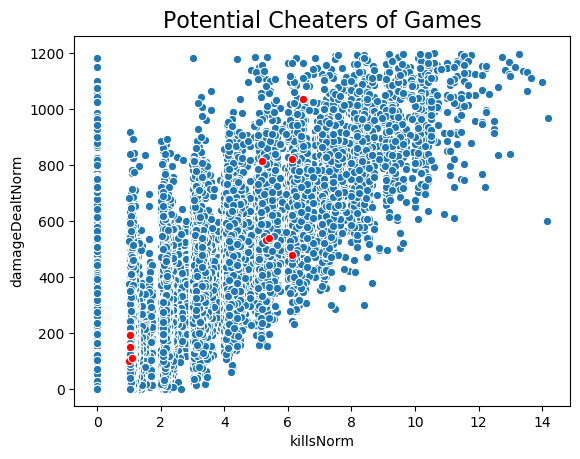

In [28]:
sns.scatterplot(df.killsNorm, df.damageDealtNorm)
sns.scatterplot(cheaters_kills,cheaters_damage, color= 'red')
plt.title("Potential Cheaters of Games", fontsize = 16)
plt.show()

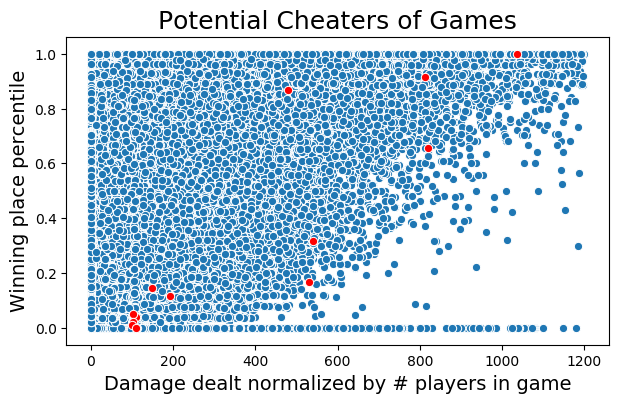

In [29]:
plt.figure(figsize = (7,4))
sns.scatterplot(df.damageDealtNorm, df.winPlacePerc)
sns.scatterplot(cheaters_damage,cheaters_win, color= 'red')
plt.ylabel("Winning place percentile", fontsize = 14)
plt.xlabel("Damage dealt normalized by # players in game", fontsize = 14)
plt.title("Potential Cheaters of Games",fontsize = 18)
plt.show()

Since the mean of kills is 0.88 and the distribution is very right skewed, having 5 kills is already pretty high. But this may not be the best metrics to indicate whether the player is a cheater, causing some false positives for very good players.

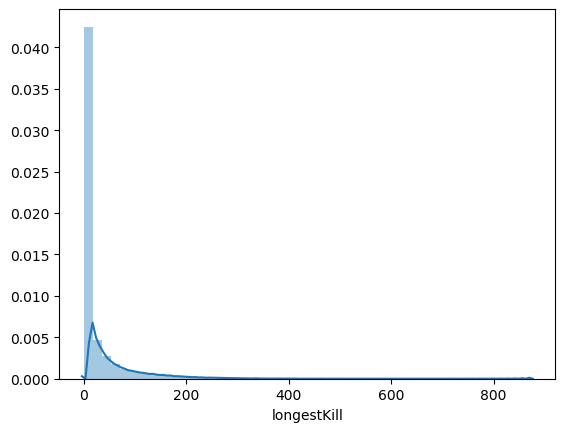

(140, 21)


In [30]:
sns.distplot(df['longestKill'])
plt.show()
print(df[(df.longestKill > 400)].shape)
df = df.drop(df[(df.longestKill > 400)].index)

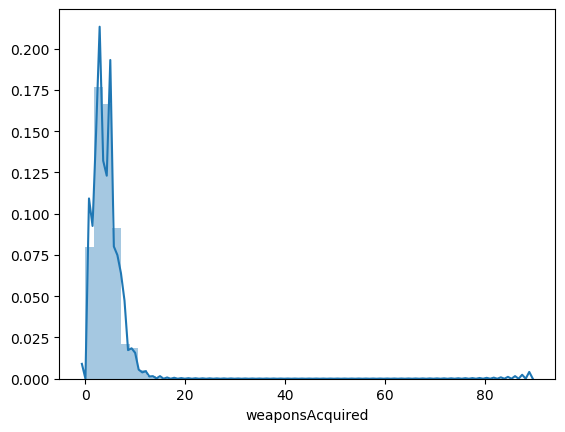

In [31]:
sns.distplot(df.weaponsAcquired)
plt.show()

In [32]:
display(df[(df.weaponsAcquired > 50)].shape)
df = df.drop(df[(df.weaponsAcquired > 50)].index)

(7, 21)

In [33]:
# longest kill distance and weapons acquired may not be the best indicator for cheaters, but they are still outliers.
print("{} potential cheaters detected and removed".format(7 + 6))

13 potential cheaters detected and removed


## Zombies?

In [34]:
# check those players who do not move at all
print(df[(df.totalDistance == 0)].shape)

(5900, 21)


In [35]:
# check those players who have no resource collected and move distance smaller than 20
print(df.totalDistance.describe())
print(df[(df.boost_heals == 0) & (df.totalDistance <= 20)].shape)


count    172636.000000
mean       2022.558771
std        2333.584793
min           0.000000
25%         193.803163
50%        1051.363540
75%        3210.715747
max       38634.661580
Name: totalDistance, dtype: float64
(10588, 21)


In [36]:
# check players have no kills, no weapons collected, and no heals and boosts
print(df[(df.boost_heals == 0) & (df.killsNorm == 0) & (df.weaponsAcquired == 0)].shape)


(7995, 21)


In [37]:
# who are these zombies
df_zombies = df[(df.totalDistance == 0) | ((df.boost_heals == 0) & (df.totalDistance <= 20)) | ((df.boost_heals == 0) & (df.killsNorm == 0) & (df.weaponsAcquired == 0))]

In [38]:
df_zombies.shape

(13910, 21)

In [39]:
zombies_kill = df_zombies.killsNorm
zombies_damage = df_zombies.damageDealtNorm
zombies_win = df_zombies.winPlacePerc

In [40]:
# drop potential zombies
df = df.drop(df[(df.totalDistance == 0)].index)
df = df.drop(df[(df.boost_heals == 0) & (df.totalDistance <= 20)].index)
df = df.drop(df[(df.boost_heals == 0) & (df.killsNorm == 0) & (df.weaponsAcquired == 0)].index)

# print("{} total Zombies removed.".format(df_zombies.shape[0]))

Text(0.5, 1.0, 'Potential Zombies of Games')

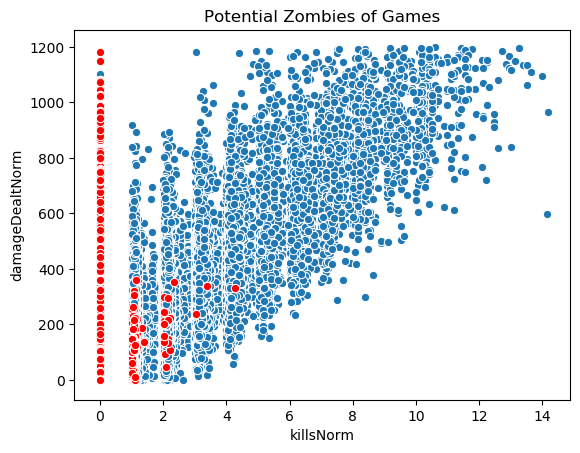

In [41]:
# plot zombies
sns.scatterplot(df.killsNorm, df.damageDealtNorm)
sns.scatterplot(zombies_kill,zombies_damage, color= 'red')
plt.title("Potential Zombies of Games")


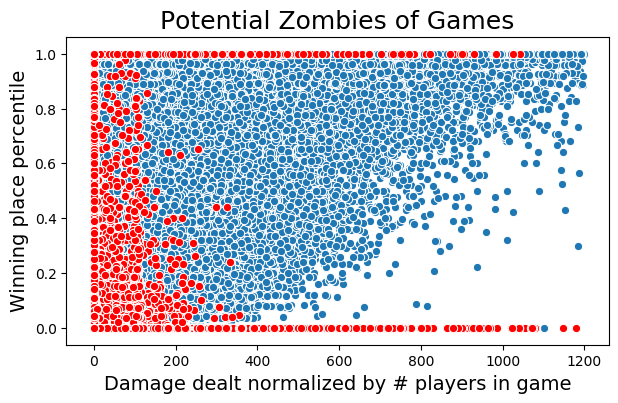

In [42]:
# plot zombies
plt.figure(figsize = (7,4))

sns.scatterplot(df.damageDealtNorm, df.winPlacePerc)
sns.scatterplot(zombies_damage,zombies_win, color= 'red')

plt.ylabel("Winning place percentile", fontsize = 14)
plt.xlabel("Damage dealt normalized by # players in game", fontsize = 14)
plt.title("Potential Zombies of Games",fontsize = 18)
plt.show()


# Clustering

## K-means cluster


In [43]:
# prepare data
# drop columns not useful for clustering players
df_train = df.loc[:,['vehicleDestroys', 'weaponsAcquired', 'damageDealtNorm','totalDistance']]
df_train.shape

(158726, 4)

In [39]:
# normalize data on example level
import sklearn.preprocessing

df_train = sklearn.preprocessing.normalize(df_train, norm='l2', axis=1, copy=True, return_norm=False)

In [45]:
# import model
from sklearn.cluster import KMeans

# find out the optimal clusters
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, init='k-means++')
    km = km.fit(df_train)
    Sum_of_squared_distances.append(km.inertia_)

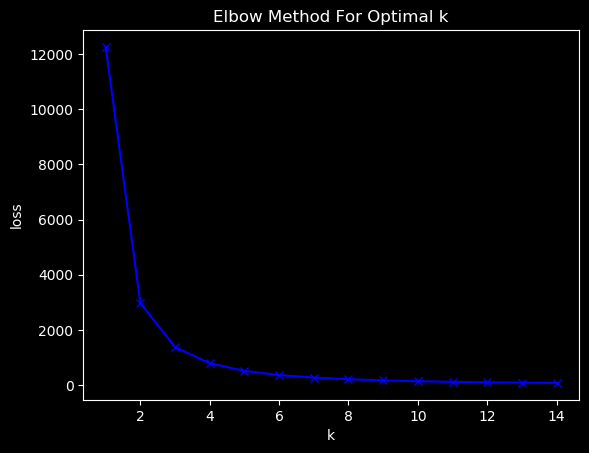

In [287]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel("loss")
plt.title('Elbow Method For Optimal k')
plt.show()

Initial assumption for k is **three**. From the EDA for predicting win place of each player, we know that the player's winning percentile is most positively correlated with three types of statistics: killing stats, items acquired, and running distances. With this assumption in mind, we rely on statistical method of sum of squared distances to support our assumption as above. And we confirm that our proof of concept for optimal k is 3.

In [47]:
kmeans = KMeans(n_clusters=3, init = 'k-means++').fit(df_train)
%time

CPU times: user 9 µs, sys: 1 µs, total: 10 µs
Wall time: 4.77 µs


In [56]:
# create cluster label to original dataset
df['cluster'] = kmeans.labels_

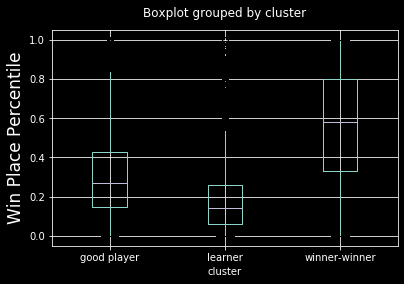

In [50]:
# winPlace
# Creates just a figure and only one subplot
# fig, ax = plt.subplots(figsize = (20,10))

pd.DataFrame(df.loc[:,['cluster','winPlacePerc']]).boxplot(by='cluster')
# sns.boxplot(x = 'winPlacePerc', data = df, hue = 'cluster')
plt.ylabel("Win Place Percentile", fontsize = 17)
plt.xlabel("cluster")
plt.title(" ")
plt.show()

In [49]:
# rename label
df['cluster'] = np.where(df['cluster'] == 1, 'winner-winner', 
         (np.where(df['cluster'] == 2, 'good player', 'learner')))

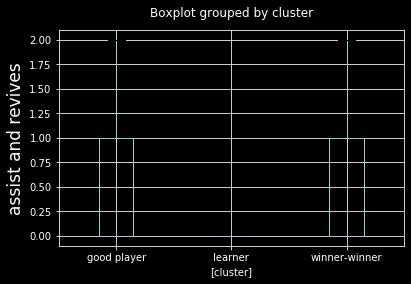

In [51]:
# assist revives
pd.DataFrame(df.loc[:,['cluster','assist_revives']]).boxplot(by='cluster', showfliers = False)
plt.title(" ")
plt.ylabel("assist and revives",fontsize = 17)
plt.show()

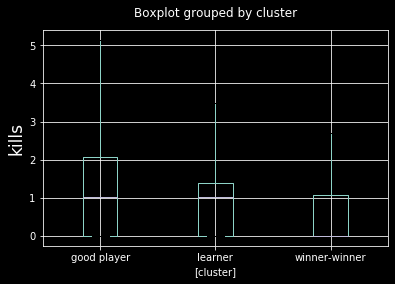

In [52]:
# kills
pd.DataFrame(df.loc[:,['cluster','killsNorm']]).boxplot(by='cluster',showfliers = False)
plt.title(" ")
plt.ylabel("kills", fontsize = 17)
plt.show()

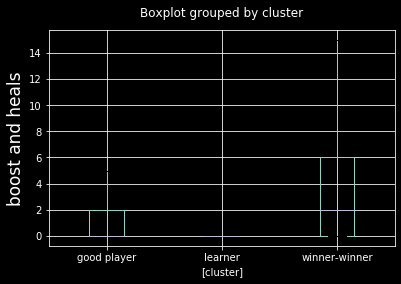

In [53]:
# heals boosts
pd.DataFrame(df.loc[:,['cluster','boost_heals']]).boxplot(by='cluster', showfliers = False)
plt.title("")
plt.ylabel("boost and heals", fontsize = 17)
plt.show()

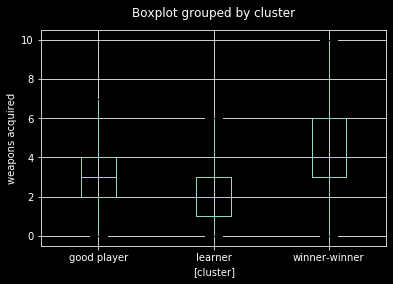

In [54]:
# weapon acquired
pd.DataFrame(df.loc[:,['cluster','weaponsAcquired']]).boxplot(by='cluster', showfliers = False)
plt.title(" ")
plt.ylabel("weapons acquired")
plt.show()

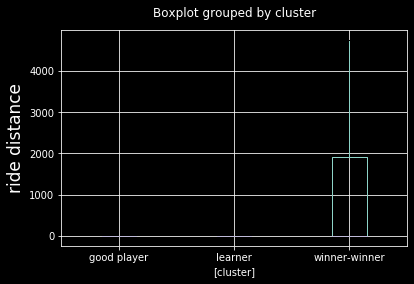

In [55]:
# distance
pd.DataFrame(df.loc[:,['cluster','rideDistance']]).boxplot(by='cluster', showfliers = False)
plt.title("")
plt.ylabel("ride distance", fontsize = 17)
plt.show()

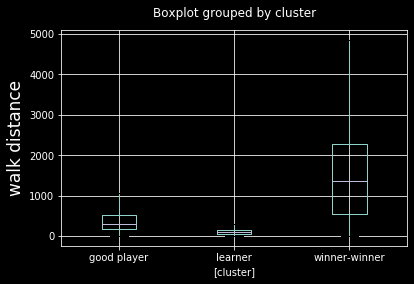

In [56]:
# distance
pd.DataFrame(df.loc[:,['cluster','walkDistance']]).boxplot(by='cluster', showfliers = False)
plt.title("")
plt.ylabel("walk distance", fontsize = 17)
plt.show()

# Anomaly Detection

In [94]:
def anomalyDetection(df_train, df, threshold = 0.01, k = 3):
    """
    Get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly.
    An estimation of anomly population of the dataset (necessary for several algorithm). 
    Calculate the number of outlier points. If the distance of points from cluster centroidis greater than 
    certain threshold then we classify the point as an outlier.
    
    args:
        df_train: np.ndarray of the training data used for clustering.
        df: original DataFrame.
        
    kwargs:
        threshold: float for setting the threshold of anomalies.
        k: number of clusters of which the model is trained.
        
    return: a DataFrame object with the anomaly label.
    """
    # distances to all clusters
    alldistances = kmeans.fit_transform(df_train)
    # distance to the closest cluster
    totalDistance = np.min(alldistances, axis=1)
    
    # create label for the distance from the closest cluster
    df['distanceCluster'] = totalDistance
    
    # get anomaly points where far from the cluster centroid by 1%
    anomaly_fraction = threshold 
    number_of_anomalies = int(anomaly_fraction*len(df))
    anomalies_cluster = number_of_anomalies//k
    lst_anomaly_index = list(df.sort_values(['cluster','distanceCluster'], ascending = False).groupby('cluster').head(anomalies_cluster).index)
    
    # create anomaly label
    dct_anomaly = {k:0 for k in range(totalDistance.shape[0])}
    for i in lst_anomaly_index:
        dct_anomaly[i] = 1
    df['anomaly'] = list(dct_anomaly.values())[:len(df)]
    
    return df
    

In [95]:
df = anomalyDetection(df_train, df)

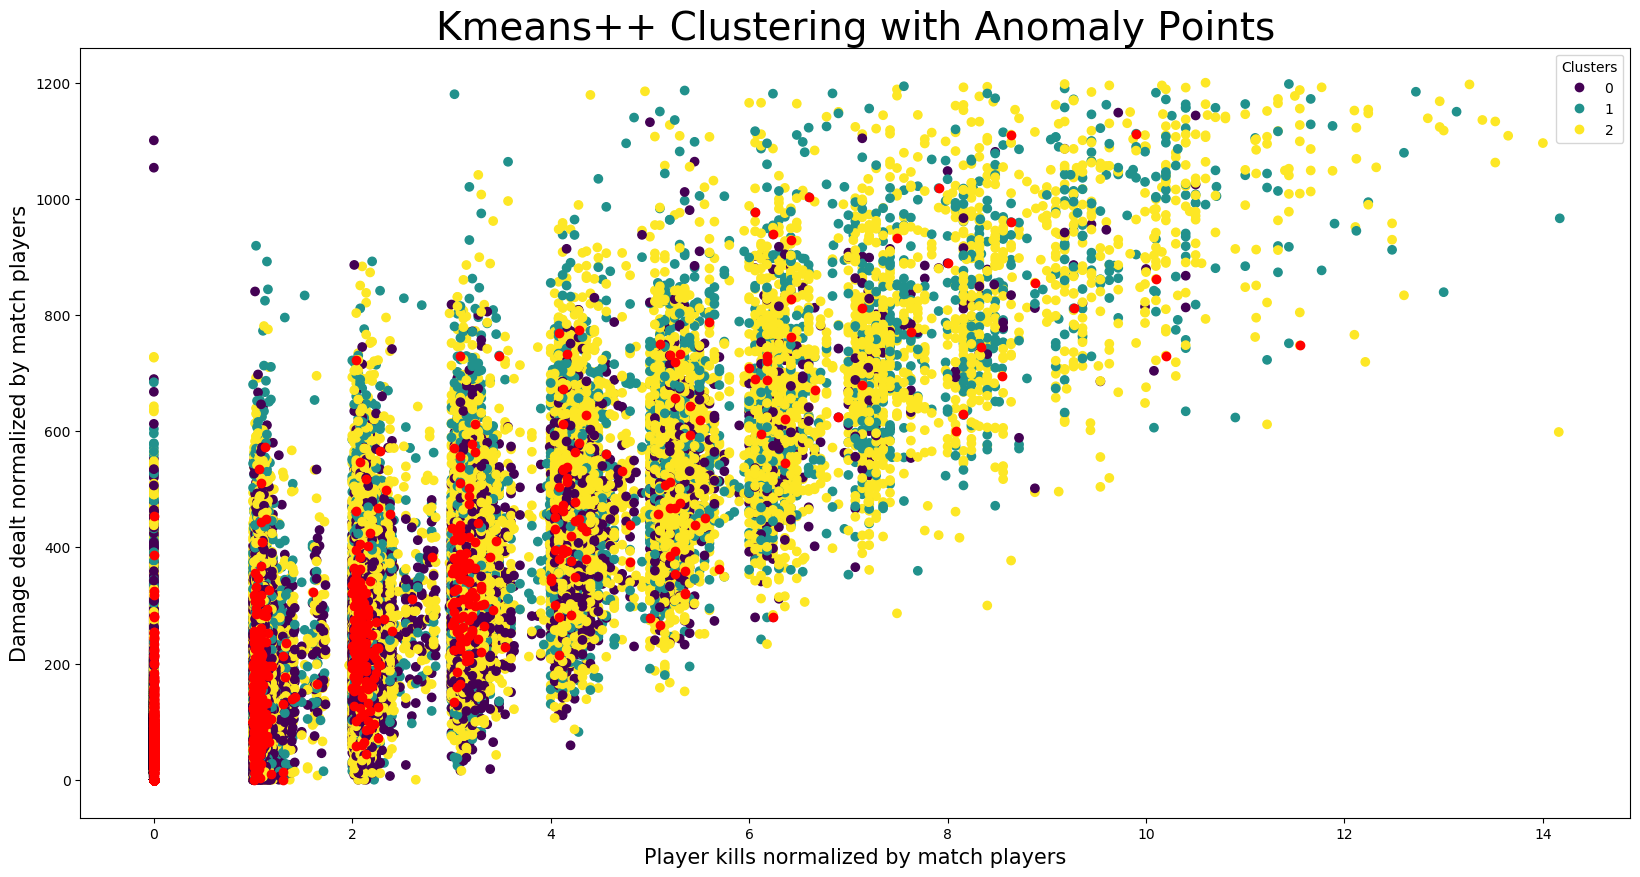

In [97]:
#Plot the clustering results based on FPD relative change in days and FPD Cumulative change in days
plt.style.use('default')
fig, ax = plt.subplots(figsize = (20,10))

anomaly_points = df[(df.anomaly) == 1]

scatter = plt.scatter(df.killsNorm, df.damageDealtNorm, c = kmeans.labels_)
anomaly = plt.scatter(anomaly_points.killsNorm, anomaly_points.damageDealtNorm, color = 'red')

legend1 = ax.legend(*scatter.legend_elements(),
            loc="upper right", title="Clusters")

plt.xlabel("Player kills normalized by match players", fontsize = 15)
plt.ylabel("Damage dealt normalized by match players", fontsize = 15)
plt.title("Kmeans++ Clustering with Anomaly Points",fontsize = 28)
plt.show()

In [106]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3,covariance_type='full')
gmm.fit(df_train)
gmm_labels = gmm.predict(df_train)


In [108]:
gmm.means_, gmm.covariances_

(array([[0.00000000e+00, 2.63639521e+00, 6.70101726e+01, 2.63692036e+02],
        [1.02506813e+00, 6.32037326e+00, 2.81062317e+02, 4.82418324e+03],
        [0.00000000e+00, 5.24900408e+00, 1.76485769e+02, 3.27019789e+03]]),
 array([[[ 1.00000000e-06,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00],
         [ 0.00000000e+00,  1.70756541e+00,  6.08282183e+00,
           1.33351704e+02],
         [ 0.00000000e+00,  6.08282183e+00,  4.89664998e+03,
           1.23801749e+03],
         [ 0.00000000e+00,  1.33351704e+02,  1.23801749e+03,
           4.41081270e+04]],
 
        [[ 1.09470250e-01, -5.79739724e-01,  1.07607057e+01,
           1.32749737e+02],
         [-5.79739724e-01,  1.62967486e+01,  1.39045571e+01,
          -6.37438329e+02],
         [ 1.07607057e+01,  1.39045571e+01,  6.18457127e+04,
           1.03970031e+05],
         [ 1.32749737e+02, -6.37438329e+02,  1.03970031e+05,
           5.95011153e+06]],
 
        [[ 1.00000000e-06,  0.00000000e+00,  0.00000000e+0

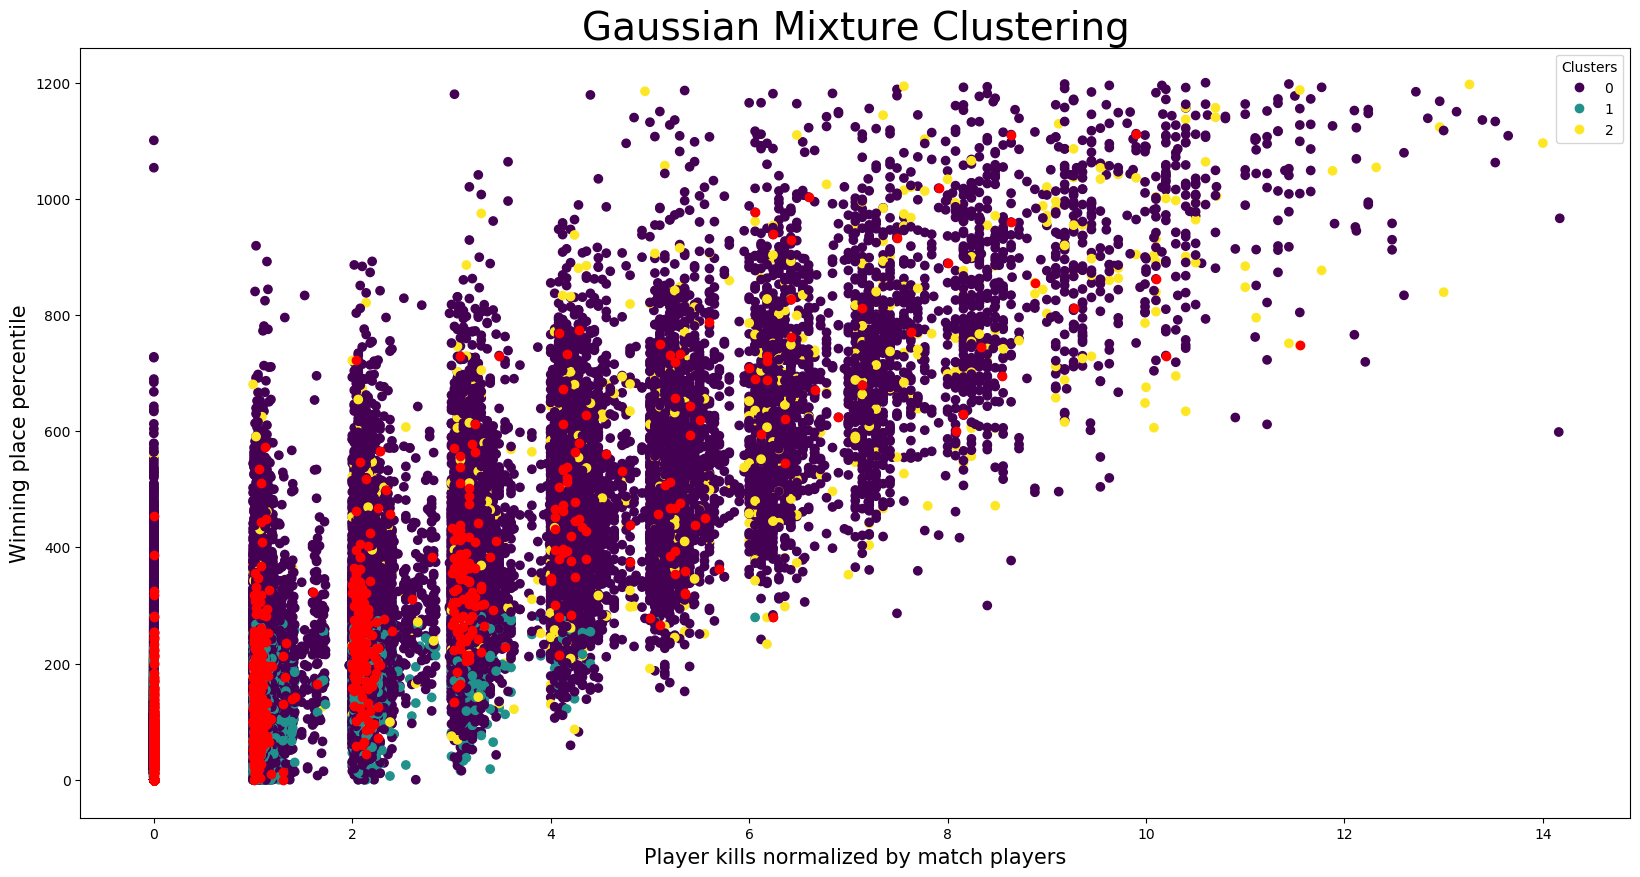

In [90]:
#Plot the clustering results based on FPD relative change in days and FPD Cumulative change in days
plt.style.use('default')

fig, ax = plt.subplots(figsize = (20,10))

# anomaly_points = df[(df.anomaly) == 1]

scatter = plt.scatter(df.killsNorm, df.damageDealtNorm, c = gmm_labels)
anomaly = plt.scatter(anomaly_points.killsNorm, anomaly_points.damageDealtNorm, c = 'red')
legend1 = ax.legend(*scatter.legend_elements(),
            loc="upper right", title="Clusters")

plt.xlabel("Player kills normalized by match players", fontsize = 15)
plt.ylabel("Winning place percentile", fontsize = 15)
plt.title("Gaussian Mixture Clustering",fontsize = 28)
plt.show()